In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MyBarrierOption as mybo
from financepy.models.black import *
from financepy.utils.global_types import *

%load_ext autoreload
%autoreload 2

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



### up and out Call Option 

In [2]:
S0 = 100
k = 100
h = 120
T = 1
q = 0.03
r = 0.05
vol = 0.20
DF = np.exp(-r*T)
DivF = np.exp(-q*T)
f = S0*DivF/DF

uo_call = mybo.BarrierOptionPrice(S0, r, q, k, h, vol, T, mybo.BarrierTypes.UP_AND_OUT_CALL)
call = Black(vol).value(f, k, T, DF, OptionTypes.EUROPEAN_CALL)

print(uo_call)
print(call)

1.107323915709415
8.652526501424305


In [3]:
DF

0.951229424500714

In [4]:
DivF

0.9704455335485082

In [5]:
# s is spot at t, t is current time, T is maturity, k is strike, r is rate between [t,T], q is div yield between [t,T]
def call_option(s, r, q, t, T, k, vol):
    DF = np.exp(-r*(T-t))
    DivF = np.exp(-q*(T-t))
    f = s*DivF/DF    
    return Black(vol).value(f, k, T-t, DF, OptionTypes.EUROPEAN_CALL)

In [6]:
numOptions = 100 # Change this to change the number of options used to replicate
ts = np.linspace(T, 0, numOptions)
Ts = list(ts[:-1])
Ts.insert(0, T)
Ks = np.ones(numOptions) * h
Ks[0] = k
ws = np.ones(numOptions)

output = np.array([Ks, Ts, ts, ws])
output = np.transpose(output)
df = pd.DataFrame(output, columns =['k', 'mat', 't', 'w']) 

for i in range(len(df)):
    if i > 0:
        t = df.loc[i, "t"]
        sum_ = 0
        for j in range(len(df)):            
            if j < i:           
                sum_ += df.loc[j,'w'] * call_option(h, r, q, t, df.loc[j,'mat'], df.loc[j,'k'], vol)
                
        res_w = -sum_/call_option(h, r, q, t, df.loc[i,'mat'], df.loc[i,'k'], vol)        
        df.loc[i,'w'] = res_w


for i in range(len(df)):
    df.loc[i, 'Value S0=100'] = df.loc[i,'w'] * call_option(S0, r, q, 0, df.loc[i,'mat'], df.loc[i,'k'], vol)
    
barrier_option = df['Value S0=100'].sum()
print(barrier_option)

#df

1.130366436854992


In [7]:
df

,k,mat,t,w,Value S0=100
0,100.0,1.000000,1.000000,1.000000,8.652527e+00
1,120.0,1.000000,0.989899,-20.547339,-5.078582e+01
2,120.0,0.989899,0.979798,8.635365,2.105175e+01
3,120.0,0.979798,0.969697,3.039503,7.307063e+00
4,120.0,0.969697,0.959596,1.567794,3.715969e+00
...,...,...,...,...,...
95,120.0,0.050505,0.040404,0.004442,1.336979e-07
96,120.0,0.040404,0.030303,0.004361,1.230261e-08
97,120.0,0.030303,0.020202,0.004277,2.605738e-10
98,120.0,0.020202,0.010101,0.004204,1.501264e-13


### Plot replication error on barrier

In [8]:
eval_t = np.linspace(0, T, 101)
eval_t

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

/Users/benny/Desktop/Projects/.venv/lib/python3.10/site-packages/financepy/models/black.py:58: RuntimeWarning: invalid value encountered in scalar divide
  r = -np.log(df)/t


Text(0.5, 1.0, 'Using 100 European Options')

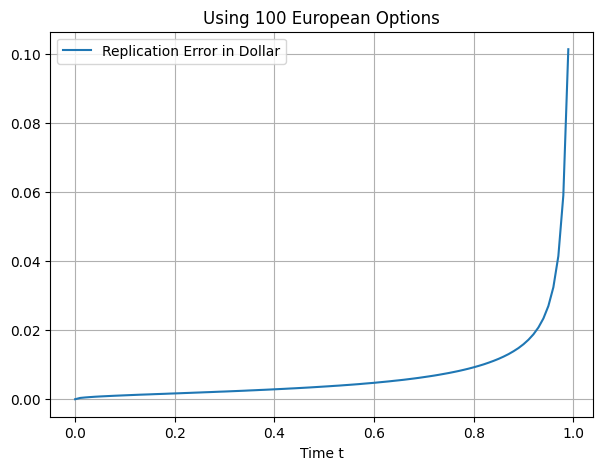

In [9]:
eval_t = np.linspace(0, T, 101)
df_error = pd.DataFrame(eval_t, columns = ['t'])
for i in range(len(df_error)):   
    t = df_error.loc[i, 't']
    value_at_barrier = 0    
    for j in range(len(df)):
        value_at_barrier += df.loc[j,'w'] * call_option(h, r, q, t, df.loc[j,'mat'], df.loc[j,'k'], vol)

    df_error.loc[i, 'Replication Error in Dollar'] = round(value_at_barrier, 5)
    
#df_error.fillna(value=0, inplace=True)
df_error.plot(x='t', y='Replication Error in Dollar', style='-', grid=True, figsize=(7, 5))
plt.xlabel("Time t")
plt.title('Using ' + str(numOptions) + ' European Options')

#plt.savefig('L6_weakstatic_' + str(numOptions) + '.png')

In [10]:
df_error.tail(50)

,t,Replication Error in Dollar
51,0.51,0.00376
52,0.52,0.00386
53,0.53,0.00395
54,0.54,0.00406
55,0.55,0.00416
56,0.56,0.00427
57,0.57,0.00438
58,0.58,0.00451
59,0.59,0.00463
60,0.60,0.00475
